In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.append('/home/azureuser/cloudfiles/code/Users/src/')

In [6]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


In [8]:
"""
Detect Methane hotspots
------------------------------
Functions to load and detect methane hotspots
"""
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import ee

# Load infra
from infrastructure import plants_as_gdf, pipelines_as_gdf

df_plants = plants_as_gdf()
df_pipelines = pipelines_as_gdf()
df_pipelines = df_pipelines[df_pipelines.geometry.notnull()]

def hotspots_as_gdf(hotspots_gpd, start_date, end_date):
    """
    Merge hotspots with infrastructure data and return list of most critical 
    methane events linked to fossil fuel production site
    :param hotspots_gpd: a geopandas dataframe of detected methane events
    :return: a geopandas dataframe with most critical events linked to fossil fule infrastructure
    """

    return (hotspots_gpd
        .assign(min_dist_plant = lambda _df: _df.apply(lambda _e: df_plants.geometry.distance(_e.geometry).min(), axis=1))
        .assign(min_dist_pipeline = lambda _df: _df.apply(lambda _e: df_pipelines.geometry.distance(_e.geometry).min(), axis=1))
        .assign(min_dist_infra = lambda _df: _df[["min_distance_to_plant", "min_distance_to_pipeline"]].min(axis=1))
        .assign(area_m2 = lambda _df: _df.geometry.area)
        # 0 criticality if more than 20km, linear in-between
        .assign(infra_dist_score = lambda _df: (20 - _df.min_distance_to_infra.clip(0, 20) / 20) )
        # log of size
        .assign(criticality = lambda _df: np.log(_df.area_m2+1) / np.log(1.01) / _df.infrastructure_distance_score)
        .sort_values(by="criticality", ascending=False)
        .assign(start_date=start_date)
        .assign(end_date=end_date)
    )


# Taken from: https://github.com/rutgerhofste/eeconvert/blob/master/eeconvert/__init__.py
def fcToGdf(fc, crs = {'init' :'epsg:4326'}):
    """converts a featurecollection to a geoPandas GeoDataFrame. Use this function only if all features have a geometry.  
    
    caveats:
    Currently only supports non-geodesic (planar) geometries because of limitations in geoPandas and Leaflet. Geodesic geometries are simply interpreted as planar geometries. 
    FeatureCollections larger than memory are currently not supported. Consider splitting data and merging (server side) afterwards. 
    
    :param fc (ee.FeatureCollection) : the earth engine feature collection to convert. 
    :param crs (dictionary, optional) : the coordinate reference system in geopandas format. Defaults to {'init' :'epsg:4326'}
    :return: gdf (geoPandas.GeoDataFrame or pandas.DataFrame) : the corresponding (geo)dataframe. 
        
    """
    crs = {'init' :'epsg:4326'}
    features = fc.getInfo()['features']
    dictarr = []

    print("Got features")
    
    for f in features:
        #geodesic = ee.Feature(f).geometry().edgesAreGeodesics()
        #if geodesic:
        attr = f['properties']
        attr['geometry'] = f['geometry']
        attr['geometry']
        dictarr.append(attr)


    gdf = gpd.GeoDataFrame(dictarr)
    gdf['geometry'] = list(map(lambda s: shapely.geometry.shape(s), gdf.geometry))
    gdf.crs = crs
    return gdf

def methane_hotspots(start_date, end_date):
    """
    Return detected methane leaks over period of interest
    :param start_date: Initial date of interest (str: 'YYYY-MM-dd')
    :param start_date: inal date of interest (str: 'YYYY-MM-dd')
    :return: ee.FeatureCollection with leaks detected
    """
    methane_volume = 'CH4_column_volume_mixing_ratio_dry_air' 
    imageCollection = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CH4')

    #Import a Landsat 8 image, subset the thermal band, and clip to the
    # area of interest.
    image = (
        imageCollection
    .select([methane_volume])
    .filterDate(start_date, end_date)
    .mean()
    .rename('ch4')
    )

    uniform_kernel = ee.Kernel.square(20, 'pixels')
    image_smooth = image.reduceNeighborhood(ee.Reducer.median(),uniform_kernel)
    diff_w_smooth = image.subtract(image_smooth)

    # Threshold the thermal band to set hot pixels as value 1, mask all else.
    hotspots_diff = (
        diff_w_smooth
        .gt(70)
        .selfMask()
        .rename('hotspots_diff')
    )

    # Start forming components from filtered areas
    objects = hotspots_diff.connectedComponents(connectedness=ee.Kernel.plus(10),maxSize=128)

    # Filter on size of objects
    objectSize = (
        objects
        .select('labels')
        .connectedPixelCount(128, False)
    )

    # Get a pixel area image.
    pixelArea = ee.Image.pixelArea()

    # Multiply pixel area by the number of pixels in an object to calculate
    # the object area. The result is an image where each pixel
    # of an object relates the area of the object in m^2.
    objectArea = objectSize.multiply(pixelArea)
    areaMask = objectArea.gte(10)

    # Update the mask of the `objects` layer defined previously using the
    # minimum area mask just defined.
    objects = objects.updateMask(areaMask)

    # Whole world extracted
    aoi = ee.Geometry.Polygon(
    [[[-179.0, 78.0], [-179.0, -58.0], [179.0, -58.0], [179.0, 78.0]]], None,
    False)
    
    toVectors = objects.reduceToVectors(
        geometry=aoi,
        crs=image.projection(),
        scale=2000,
        geometryType='polygon',
        eightConnected=False,
        labelProperty='hotspots',
        reducer=ee.Reducer.mean(),
        maxPixels=10e8,
    )

    return toVectors


def save_methane_hotspots(start_date, end_date):
    """
    Return detected methane leaks over period of interest as geopandas dataframe and save file
    :param start_date: Initial date of interest (str: 'YYYY-MM-dd')
    :param start_date: inal date of interest (str: 'YYYY-MM-dd')
    :return: 
    """
    methane_hotspots_vectors = methane_hotspots(start_date, end_date)
    gpd = fcToGdf(methane_hotspots_vectors)
    gpd.to_file(f'methane_hotspots_start_date={start_date}_end_date={end_date}.geojson', driver='GeoJSON')

    
def run(start_date, end_date, fdir='/mounted/'):
    """
    Return detected methane leaks over period of interest as geopandas dataframe and save file
    :param start_date: Initial date of interest (str: 'YYYY-MM-dd')
    :param start_date: inal date of interest (str: 'YYYY-MM-dd')
    :return: 
    """
    # From GEE
    methane_hotspots_vectors = methane_hotspots(start_date, end_date)
    # Transform to geopandas
    hotspots_gpd = fcToGdf(methane_hotspots_vectors)
    # Link with infra
    hotspot_w_infra = hotspots_as_gdf(hotspots_gpd, start_date, end_date)
    # write to disk
    gpd.to_file(f'{fdir}/methane_hotspots_start_date={start_date}_end_date={end_date}.geojson', driver='GeoJSON')
    
    return "Success"


In [ ]:
run("2021-03-14", "2021-03-21", fdir='/mounted/')
run("2021-03-07", "2021-03-14", fdir='/mounted/')
run("2021-02-28", "2021-03-07", fdir='/mounted/')

In [ ]:
run("2021-02-21", "2021-02-28", fdir='/mounted/')
run("2021-02-14", "2021-02-21", fdir='/mounted/')
run("2021-02-07", "2021-02-21", fdir='/mounted/')
run("2021-01-31", "2021-02-07", fdir='/mounted/')

# Time serie

In [5]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [15]:
import geopandas as gpd

In [17]:
fpath_hotspots = 'methane_hotspots_start_date=2021-03-01_end_date=2021-03-04.geojson'
hotspots = gpd.read_file(fpath_hotspots)

# Timeseries

In [74]:
start_date="2021-02-01"
end_date = "2021-04-01"
roi = ee.Geometry.Polygon(list(hotspots.iloc[1].geometry.exterior.coords))
im_coll = (ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_CH4')
           .filterBounds(roi)
           .filterDate(ee.Date(start_date),ee.Date(end_date))
           .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
           .sort('date'))

region_im = im_coll.getRegion(roi, 2000).getInfo()
timestamplist = (im_coll.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d)))
                 .getInfo())
#timestamplist

(1700.0, 2000.0)

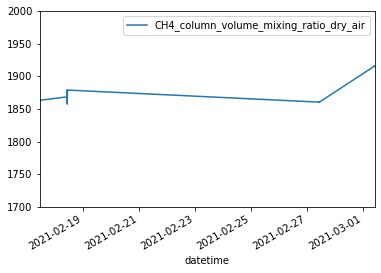

In [75]:
df_mth = ee_array_to_df(region_im, ['CH4_column_volume_mixing_ratio_dry_air'])
ax = df_mth.plot(x="datetime", y="CH4_column_volume_mixing_ratio_dry_air")
ax.set_ylim(1700, 2000)